In [107]:
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation and Treatment
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Plotting and Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-Learn for Modeling
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error,mean_squared_log_error

# Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from pmdarima import auto_arima

In [108]:
#Load the dataset
df = pd.read_csv("C:/Users/ASUS/Desktop/NFSML/NVDA4.csv", sep=",")
df.head()
df['Date'] =  pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df = df.drop('Date',axis=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-25,192.020004,199.449997,190.960007,199.020004,198.918823,64156600
2022-04-26,197.179993,197.880005,186.699997,187.880005,187.784485,65314300
2022-04-27,185.979996,191.669998,182.899994,184.149994,184.056381,49946000
2022-04-28,189.669998,200.369995,184.899994,197.820007,197.719452,57032700
2022-04-29,194.020004,201.279999,185.169998,185.470001,185.375717,50043500


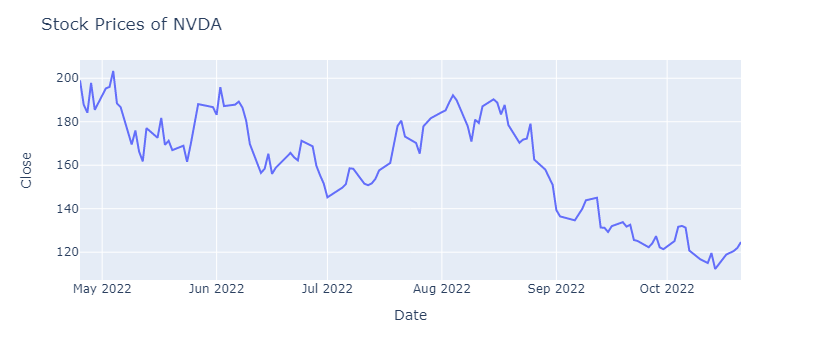

In [109]:
# Plot historical stock prices of NVDA
fig = px.line(y=df.Close, x=df.index)
fig.update_layout(title_text='Stock Prices of NVDA',font=dict(size=12),
                 xaxis_title_text="Date", yaxis_title_text="Close")
fig.show()

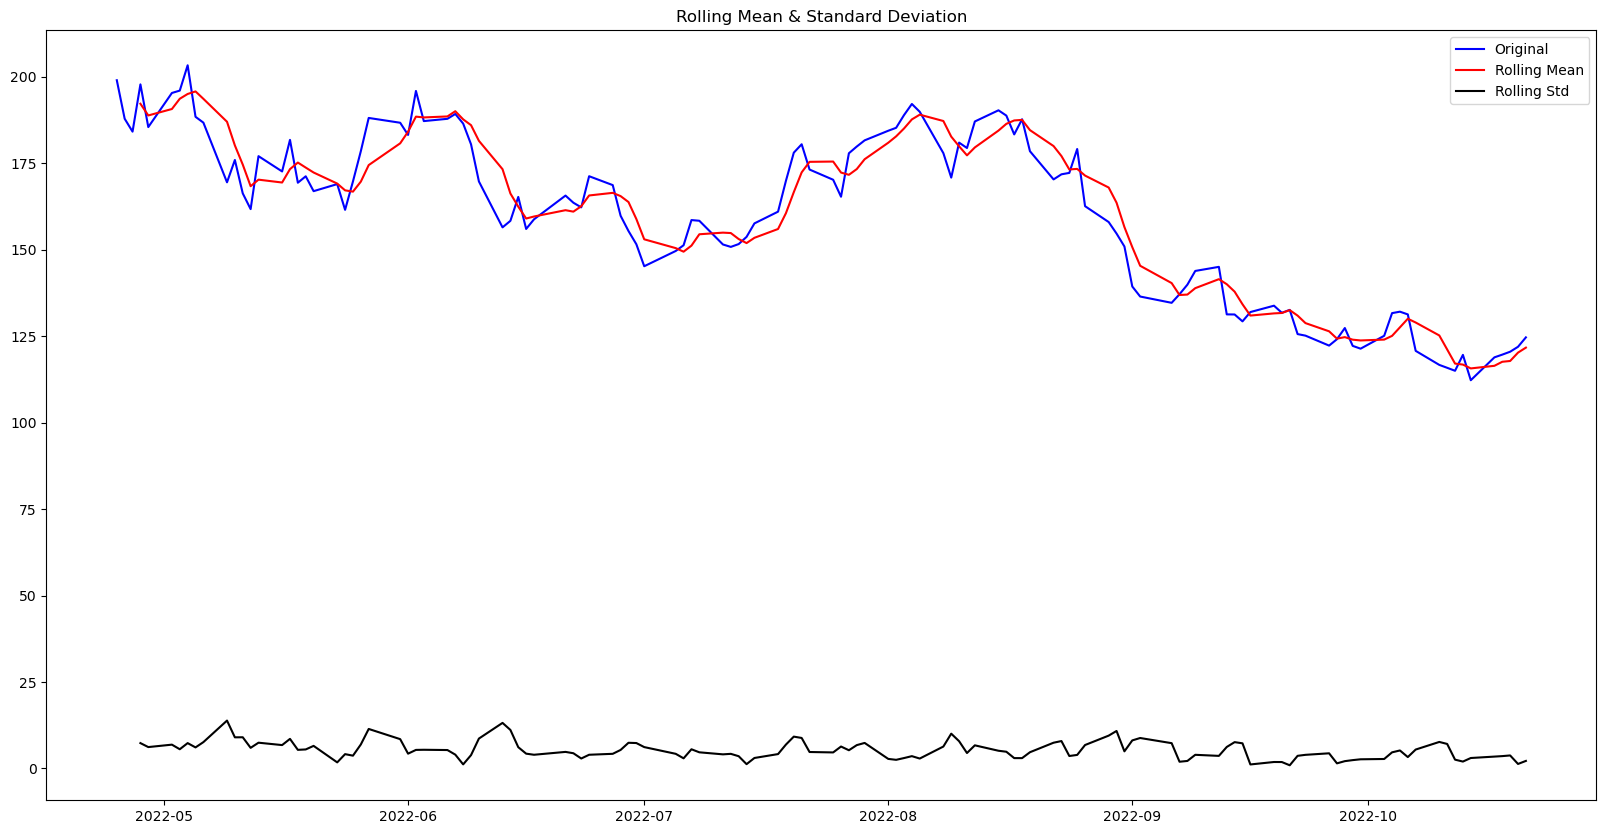

Results of Dickey-Fuller Test:
Test Statistic                 -1.595019
p-value                         0.486095
#Lags Used                      0.000000
Number of Observations Used   125.000000
Critical Value (1%)            -3.483779
dtype: float64
Test Statistic                 -1.595019
p-value                         0.486095
#Lags Used                      0.000000
Number of Observations Used   125.000000
Critical Value (1%)            -3.483779
Critical Value (5%)            -2.884954
dtype: float64
Test Statistic                 -1.595019
p-value                         0.486095
#Lags Used                      0.000000
Number of Observations Used   125.000000
Critical Value (1%)            -3.483779
Critical Value (5%)            -2.884954
Critical Value (10%)           -2.579257
dtype: float64
result : time series is not stationary


In [110]:
# Checking Stationarity - Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller 

# Function for testing stationarity
def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(4).mean() # around 4 weeks on each month
    rolstd = timeseries.rolling(4).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput)
    
    if dfoutput['p-value'] < 0.05:
        print('result : time series is stationary')
    else : print('result : time series is not stationary')

from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(df['Close'])

# p-value obtained is greater that the significance level of 0.05
# Hence, we do not reject the null hypothesis, time series is non-stationary
# Need to use "integrated" (i.e. I in ARIMA) concept to make data stationary

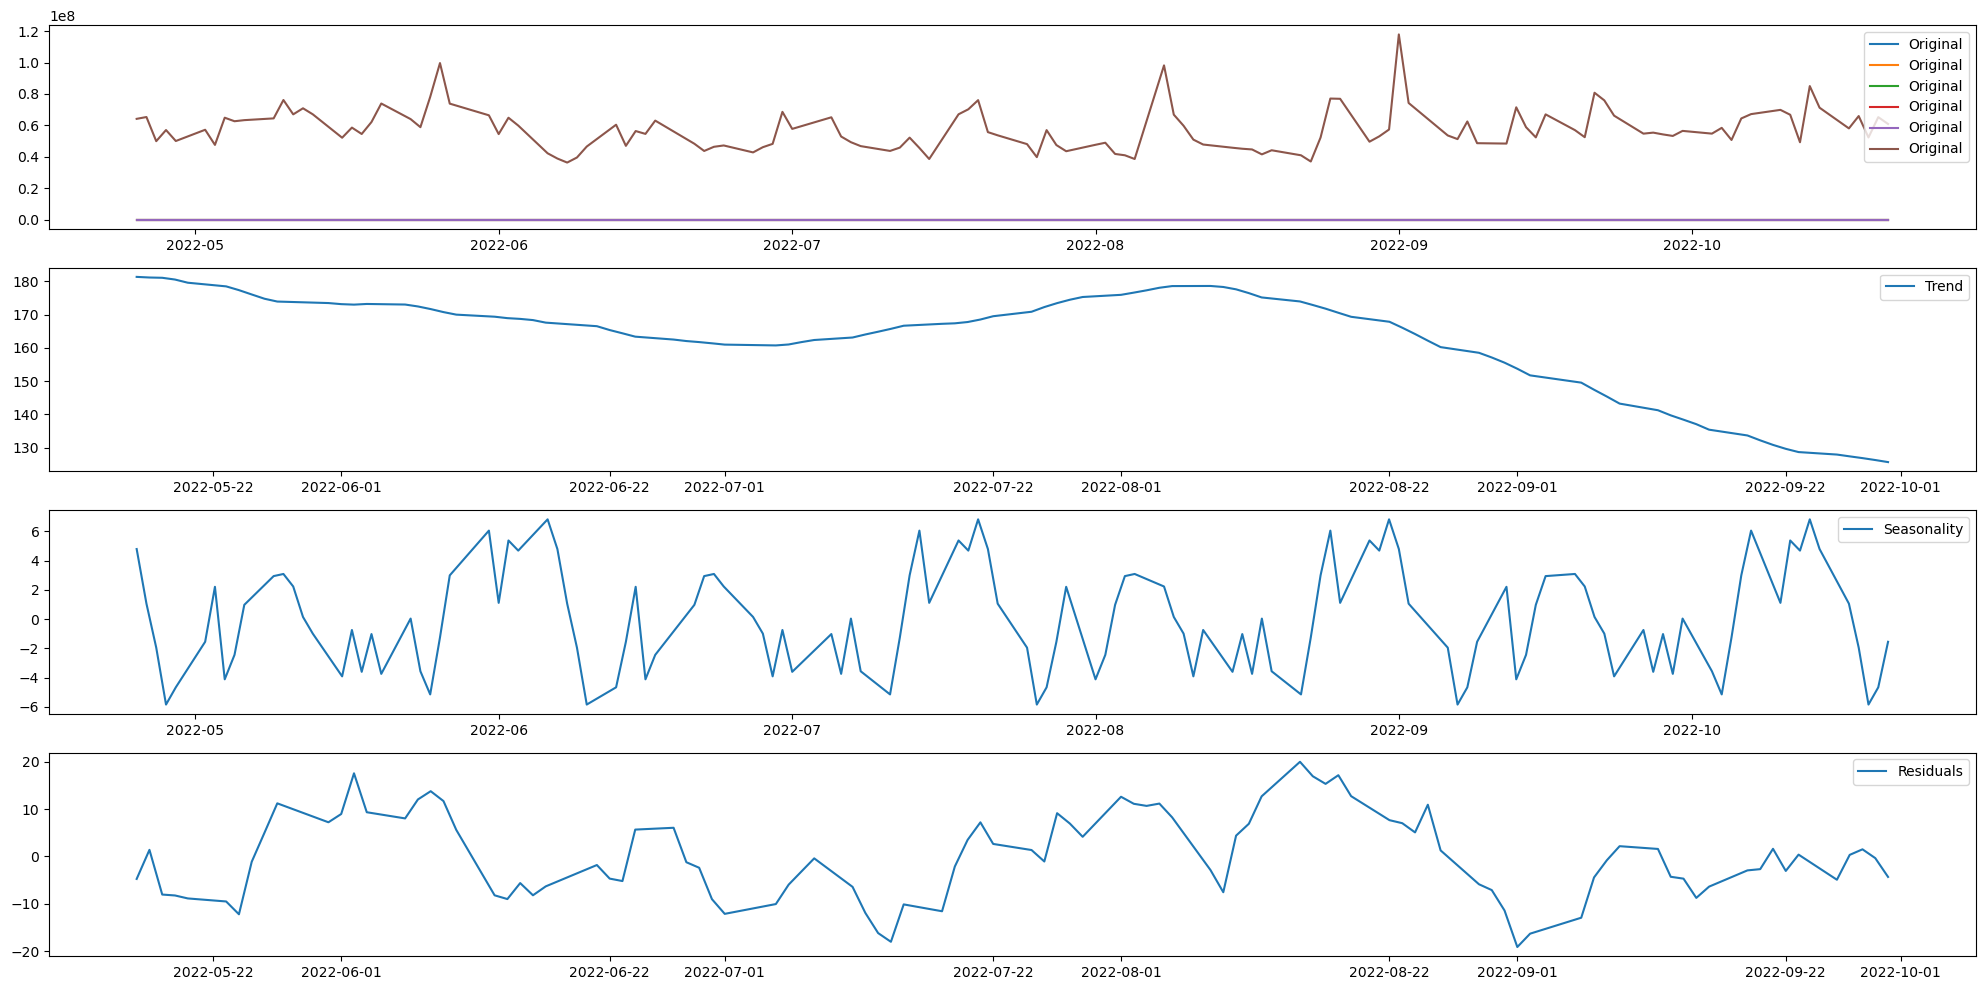

In [111]:
# Checking Trend and Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

df_close = df['Close']
decomposition = seasonal_decompose(df_close, period=30)

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid

plt.subplot(411) 
plt.plot(df, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

In [112]:
# Split the data into train and test sets
model_train = df.iloc[:int(df.shape[0]*0.80)]
valid = df.iloc[int(df.shape[0]*0.80):]
y_pred = valid.copy()

In [113]:
# Use auto_arima to determine the optimal p, q, d for the ARIMA model
model_scores_r2 = []
model_scores_mse = []
model_scores_rmse = []
model_scores_mae = []
model_scores_rmsle = []
model_arima = auto_arima(model_train["Close"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
              suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Close"])

# Optimal p, q, d are 1, 1, 3 respectively

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=673.196, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=674.389, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=675.789, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=676.960, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=674.260, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=675.211, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=676.979, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=678.546, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=675.584, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=680.156, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=676.792, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=678.022, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=680.057, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

In [114]:
prediction_arima = model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"] = prediction_arima

r2_arima = r2_score(y_pred["Close"],y_pred["ARIMA Model Prediction"])
mse_arima = mean_squared_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
rmse_arima = np.sqrt(mean_squared_error(y_pred["Close"],y_pred["ARIMA Model Prediction"]))
mae_arima = mean_absolute_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
rmsle_arima = np.sqrt(mean_squared_log_error(y_pred["Close"],y_pred["ARIMA Model Prediction"]))

model_scores_r2.append(r2_arima)
model_scores_mse.append(mse_arima)
model_scores_rmse.append(rmse_arima)
model_scores_mae.append(mae_arima)
model_scores_rmsle.append(rmsle_arima)
print("R Square Score ARIMA: ",r2_arima)
print("Mean Square Error ARIMA: ",mse_arima)
print("Root Mean Square Error ARIMA: ",rmse_arima)
print("Mean Absoulute Error ARIMA: ",mae_arima)
print("Root Mean Squared Logarithmic Error ARIMA: ", rmsle_arima)

R Square Score ARIMA:  -0.13873124990276797
Mean Square Error ARIMA:  40.790984893341104
Root Mean Square Error ARIMA:  6.386782045235386
Mean Absoulute Error ARIMA:  4.76524852447554
Root Mean Squared Logarithmic Error ARIMA:  0.05196179915747414


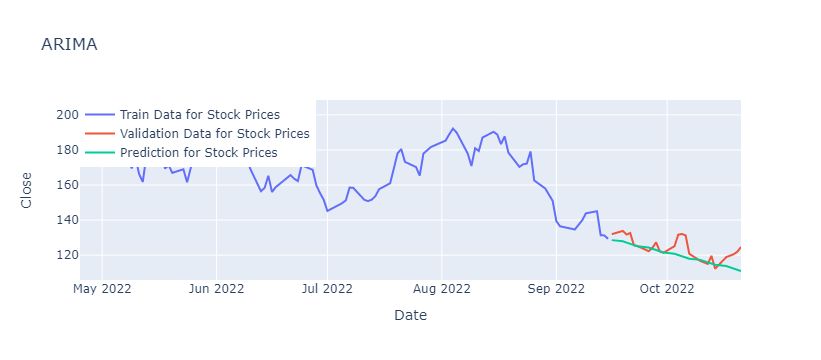

In [115]:
# Use model to forecast test data closing price
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Close"], mode='lines',name="Train Data for Stock Prices"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Close"], mode='lines',name="Validation Data for Stock Prices",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"], mode='lines',name="Prediction for Stock Prices",))
fig.update_layout(title="ARIMA",xaxis_title="Date",yaxis_title="Close",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=12))
fig.show()

In [130]:
ARIMA_model_new_date=[]
ARIMA_model_new_prediction=[]
for i in range(3,15):
    if (i != 8 and i != 9):
        ARIMA_model_new_date.append(i-3)
        ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
    
        
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions = pd.DataFrame(zip(ARIMA_model_new_date,ARIMA_model_new_prediction), 
                                 columns=["index","Close"])
model_predictions

,index,Close
0,0,108.864030
1,1,108.159687
2,2,107.455343
3,3,106.751000
4,4,106.046656
5,7,103.933625
6,8,103.229282
7,9,102.524938
8,10,101.820595
9,11,101.116251


In [131]:
model_predictions.to_csv("C:/Users/ASUS/Desktop/NFSML/Shen_Licong_Impl_2.csv", index=False)